# Loading packages

In [1]:
!pip install imutils

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from imutils.perspective import four_point_transform
from imutils import contours
import imutils

# Function definition

In [4]:
def adjust_gamma(image, gamma=1): #source : https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
 
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

In [5]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
 
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	# return the ordered coordinates
	return rect

In [36]:
def preprocessing(image, gamma_value = 2):
    # Step 1: pre-process the image by resizing it, converting it to graycale, blurring it and adjusting the constrast on a custom level
    image = imutils.resize(image, height=1000) #Not more needed
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    gamma = adjust_gamma(blurred, gamma = gamma_value) #build more contrast on the image
    edged = cv2.threshold(gamma, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # Step 2: find contours and build the edge map then we will process the edges to find the right fit for the screen
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    displayCnt = None

    # loop over the contours to approximate them and select the largest one having 4 vertices (screen shape)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            displayCnt = approx
            break
    
    # Step 3: extract the LCS screen and transform it with a perspective correction. Two different fonctions are used
    if displayCnt is not None:
        warped = four_point_transform(gray, displayCnt.reshape(4, 2))
        output = four_point_transform(image, displayCnt.reshape(4, 2))
        
        #Case 1: if the four_point_transform function succeeds, we use it since it is the most accurate method
        nbpixelcount = cv2.countNonZero(cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)) / (output.shape[0] * output.shape[1])
        if nbpixelcount > 0.6: #The transformation suceeded if there aren't over 60% all black pixels
            return output
        else: #Case 2: we use the getPerspectiveTransform function, which is less precise but works well. In this case we manually imput the screen since as 400*100 pixels
            displayCnt = displayCnt.reshape(4, 2).astype(np.float32)
            displayCnt = order_points(displayCnt)
            displayDst = np.array([[0, 0], [400, 0], [400, 100], [0, 100]]).astype(np.float32)

            M = cv2.getPerspectiveTransform(displayCnt, displayDst) #Transformation matrix
            output = cv2.warpPerspective(image, M, (400, 100))
            return output
    else: # return a column if a 4 vertices shape can't be found, this will be discarded by our tests later on
        return np.array([[1], [1], [1]])

source : https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

https://stackoverflow.com/questions/42262198/4-point-persective-transform-failure

# Using the function

## On the whole folder for HQ

In [9]:
image_list = os.listdir('data//HQ_digital//')

for img in image_list:
    image = cv2.imread(os.path.join('data//HQ_digital//',img))    
    if( (preprocessing(image, 2).shape[1] > 2*preprocessing(image, 2).shape[0]) & (preprocessing(image, 2).shape[0] * preprocessing(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//HQ_digital//' + img, preprocessing(image, 2))
        print("step 1")
    elif ((preprocessing(image, 0.3).shape[1] > 2*preprocessing(image, 0.3).shape[0])& (preprocessing(image, .3).shape[0] * preprocessing(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//HQ_digital//' + img, preprocessing(image, 0.3))
        print("step 2")
    elif ((preprocessing(image, 0.7).shape[1] > 2*preprocessing(image, 0.7).shape[0])& (preprocessing(image, .7).shape[0] * preprocessing(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//HQ_digital//' + img, preprocessing(image, 0.7))
        print("step 3")
    elif ((preprocessing(image, 0.1).shape[1] > 2*preprocessing(image, 0.1).shape[0])& (preprocessing(image, 0.1).shape[0] * preprocessing(image, 0.1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//HQ_digital//' + img, preprocessing(image, 0.1))
        print("step 4")
    else:
        print("------------------------------------------------------- Human intervention needed - " + img)

step 1
step 1
step 1
------------------------------------------------------- Human intervention needed - 05f3d4b586d92ba18b00dedd6dbe4a163f9ea1c1.jpg
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 3
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
------------------------------------------------------- Human intervention needed - 5232b54dc19f64026dde07b3d3f3b7b868162352.jpg
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 1
step 3
step 1
step 1
step 1
step 1
step 1
------------------------------------------------------- Human intervention needed - 67fcfc525568301048c4eeb4554173013daed55a.jpg
step 1
step 1
step 1
step 1
step 1
step 1
step 2
step 1
-------------------------

135 / 218 -> 62% accuracy

190 / 218 -> 87% accuracy using method 2 without canny

198 / 218 -> 91% accuracy with the conditions and gamma ameliorations

200 / 218 --> 92% accuracy with the size condition -- 211/218 ne sont pas déclarées comme intraitables

10 wrong detections and 7 fails

201 / 218 -> 92.2 %

205 / 218 -> 94.0 %
    --> 6 detected as wrong
    --> 7 wrong output

## Using on the whole LQ_digital dataset

In [10]:
image_list = os.listdir('data//LQ_digital//')

for img in image_list:
    image = cv2.imread(os.path.join('data//LQ_digital//',img))    
    if( (preprocessing(image, 2).shape[1] > 2*preprocessing(image, 2).shape[0]) & (preprocessing(image, 2).shape[0] * preprocessing(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//LQ_digital//' + img, preprocessing(image, 2))
        print("step 1")
    elif ((preprocessing(image, 0.3).shape[1] > 2*preprocessing(image, 0.3).shape[0])& (preprocessing(image, .3).shape[0] * preprocessing(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//LQ_digital//' + img, preprocessing(image, 0.3))
        print("step 2")
    elif ((preprocessing(image, 0.7).shape[1] > 2*preprocessing(image, 0.7).shape[0])& (preprocessing(image, .7).shape[0] * preprocessing(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//LQ_digital//' + img, preprocessing(image, 0.7))
        print("step 3")
    elif ((preprocessing(image, 0.1).shape[1] > 2*preprocessing(image, 0.1).shape[0])& (preprocessing(image, 0.1).shape[0] * preprocessing(image, 0.1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//LQ_digital//' + img, preprocessing(image, 0.1))
        print("step 4")
    else:
        print("------------------------------------------------------- Human intervention needed - " + img)

step 1
step 1
step 1
step 1
step 1
step 2
step 1
------------------------------------------------------- Human intervention needed - 0098fde1754c51028bb4785e9eb5ef39519c1e16.jpg
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 2
step 1
------------------------------------------------------- Human intervention needed - 028db92ffbe41bbdc0c7071239e1d579eb3e0792.jpg
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 2
step 1
------------------------------------------------------- Human intervention needed - 037498c9986c46d3bf00a96eddfbd6ce4fd50a85.jpg
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
------------------------------------------------------- Human intervention needed - 051244cbfedaa05b5319c0d9bed897558c52b069.jpg
step 1
step 1
step 1
step 2
step 1
step 1
step 2
step 1
step 1
step 2
------------------------------------------------------- Human intervention needed - 066b77046643b587686793

298 / 330 --> 90 %
    - 32 without any outputs
    - 2 weird ones but ok
    
303/330 --> 91.8 %
    - 28 without outputs
    - 2 weird but ok

## MQ Digital

In [11]:
image_list = os.listdir('data//MQ_digital//')

for img in image_list:
    image = cv2.imread(os.path.join('data//MQ_digital//',img))    
    if( (preprocessing(image, 2).shape[1] > 2*preprocessing(image, 2).shape[0]) & (preprocessing(image, 2).shape[0] * preprocessing(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//MQ_digital//' + img, preprocessing(image, 2))
        print("step 1")
    elif ((preprocessing(image, 0.3).shape[1] > 2*preprocessing(image, 0.3).shape[0])& (preprocessing(image, .3).shape[0] * preprocessing(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//MQ_digital//' + img, preprocessing(image, 0.3))
        print("step 2")
    elif ((preprocessing(image, 0.7).shape[1] > 2*preprocessing(image, 0.7).shape[0])& (preprocessing(image, .7).shape[0] * preprocessing(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//MQ_digital//' + img, preprocessing(image, 0.7))
        print("step 3")
    elif ((preprocessing(image, 0.1).shape[1] > 2*preprocessing(image, 0.1).shape[0])& (preprocessing(image, 0.1).shape[0] * preprocessing(image, 0.1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results//MQ_digital//' + img, preprocessing(image, 0.1))
        print("step 4")
    else:
        print("------------------------------------------------------- Human intervention needed - " + img)

step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 2
step 2
step 1
------------------------------------------------------- Human intervention needed - 023d80491ecf06ebf29ec6968873e2b9d0b5c0bf.jpg
step 3
step 1
step 1
step 1
------------------------------------------------------- Human intervention needed - 03556ee4ee8f746df21b1a90bbe4d7bbe75e80cd.jpg
------------------------------------------------------- Human intervention needed - 038c8b68db9d506d2e0a1fa002ae83c50d43e1ab.jpg
step 1
step 2
------------------------------------------------------- Human intervention needed - 039aabd8a299eae76af9221e0bf9fbe993311179.jpg
------------------------------------------------------- Human intervention needed - 03a49a24708ee65209e1f875fb4f6ae5a4e31d68.jpg
step 1
step 1
step 3
step 2
step 1
step 1
step 3
step 3
step 3
step 1
step 2
------------------------------------------------------- Human intervention needed - 04e18c833430396cf96dd2a5f51e5872ad8180e2.jpg
step 1
step 4
step 1
st

188 / 225 --> 83 %

# Exploration

In [7]:
def preprocessing_brut(image, gamma_value = 2):
    # Step 1: pre-process the image by resizing it, converting it to graycale, blurring it and adjusting the constrast on a custom level
    image = imutils.resize(image, height=1000) #Not more needed
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    gamma = adjust_gamma(blurred, gamma = gamma_value) #build more contrast on the image
    edged = cv2.threshold(gamma, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    # Step 2: find contours and build the edge map then we will process the edges to find the right fit for the screen
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    displayCnt = None

    # loop over the contours to approximate them and select the largest one having 4 vertices (screen shape)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            displayCnt = approx
            break
    
    # Step 3: extract the LCS screen and transform it with a perspective correction
    if displayCnt is not None:
        #using another method less precise
            displayCnt = displayCnt.reshape(4, 2).astype(np.float32)
            displayCnt = order_points(displayCnt)
            displayDst = np.array([[0, 0], [400, 0], [400, 100], [0, 100]]).astype(np.float32)

            M = cv2.getPerspectiveTransform(displayCnt, displayDst) #Transformation matrix
            output = cv2.warpPerspective(image, M, (400, 100))
            return output
    else: # return a column if a 4 vertices shape can't be found, this will be discarded by our tests later on
        return np.array([[1], [1], [1]])

## On a single image

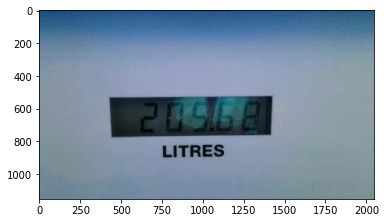

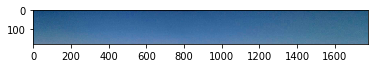

In [8]:
# load the example image
#i = 'data//HQ_digital//3143a8b25a7f6f9ac1b47475d010ea6d113270b8.jpg'

#i = 'data//HQ_digital//f459be06cce486e8199930cfb3ed8c42d2f1a4b8.jpg'
#i = 'data//HQ_digital//f8078b64f04fff2627fa142eb26084a166870bd4.jpg'

#cv2.imread('data/LQ_digital/20af9eb08dd82985ebd33947f51bd9268e1bb20a.jpg')

#image = cv2.imread('data/HQ_digital/659667ef81a9faea100e326ae165535e530785d4.jpg')
#image = cv2.imread('data/LQ_digital/2140017c78aa8e9c5bf87a6f9483d44770327d2e.jpg')
#image = cv2.imread('data/HQ_digital/bf81cd3258241d91ba9e915e8bf309da16a574ed.jpg')

#image = cv2.imread('data/HQ_digital/8ecb0b9d2fba086caf434b7a4864434f9ea0da0e.jpg') #Marche avec .3 au lieu de 2

#image = cv2.imread('data/HQ_digital/67fcfc525568301048c4eeb4554173013daed55a.jpg') #Marche avec .1

image = cv2.imread('data/HQ_digital/dd31a247c313689d77bbf8fbf2bd7dbac8d44333.jpg') #Marche avec .1

plt.figure()
plt.imshow(image)
plt.show()
plt.imshow(preprocessing(image, .3))

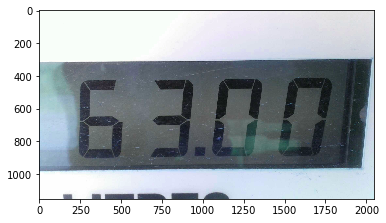

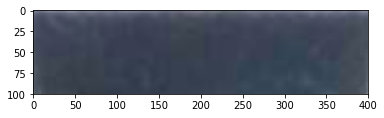

In [67]:
#image = cv2.imread('data/LQ_digital/1b4168c6e014d9588802c70e74cde6511c012454.jpg') #Image trop claire
#image = cv2.imread('data/LQ_digital/1bc770862ea5d73bfa42ea937b13dbfa52190852.jpg') #Image ne fonctionnant pas
#image = cv2.imread('data/LQ_digital/1dafcfe3396e0408ca82061eef6a43f9f732fb91.jpg') #Image trop claire
#image = cv2.imread('data/LQ_digital/1eaad91b157095fdf3b970673ca5cc2a23ca2f48.jpg') #Image trop claire
#image = cv2.imread('data/LQ_digital/1fbf0c07f81460ac53b80511fb55c06d32a3850c.jpg') # Image trop claire et floue
#image = cv2.imread('data/LQ_digital/1ff9eef553663acb92add0027644929822be7af9.jpg') # doigt sur la photo
#image = cv2.imread('data/LQ_digital/06f8b8924a15bbc86c9b0779827f6e559c4821cb.jpg') # Image sur exposée
#image = cv2.imread('data/LQ_digital/08ca689e9648f2874fc69a48006777bfb8e7992b.jpg') # Image sur exposée
image = cv2.imread('Dataset_test/MQ_digital_test/0c2661180b01ccf09153e3c59ff491c1b6069a39.jpg') # Image sur exposée


plt.figure()
plt.imshow(image)
plt.show()
plt.imshow(preprocessing_brut(image, 2))

# Results on the testing dataset

## HQ

In [41]:
image_list = os.listdir('Dataset_test//HQ_digital_test//')

for img in image_list:
    image = cv2.imread(os.path.join('Dataset_test//HQ_digital_test//',img))    
    if( (preprocessing(image, 2).shape[1] > 2*preprocessing(image, 2).shape[0]) & (preprocessing(image, 2).shape[0] * preprocessing(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//HQ_digital_test//' + img, preprocessing(image, 2))
        print("step 1")
    elif ((preprocessing(image, 0.3).shape[1] > 2*preprocessing(image, 0.3).shape[0])& (preprocessing(image, .3).shape[0] * preprocessing(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//HQ_digital_test//' + img, preprocessing(image, 0.3))
        print("step 2")
    elif ((preprocessing(image, 0.7).shape[1] > 2*preprocessing(image, 0.7).shape[0])& (preprocessing(image, .7).shape[0] * preprocessing(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//HQ_digital_test//' + img, preprocessing(image, 0.7))
        print("step 3")
    elif ((preprocessing(image, 0.1).shape[1] > 2*preprocessing(image, 0.1).shape[0])& (preprocessing(image, 0.1).shape[0] * preprocessing(image, 0.1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//HQ_digital_test//' + img, preprocessing(image, 0.1))
        print("step 4")
    else:
        print("-------------- Human intervention needed - " + img)

step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1


24 / 24 --> 100 %

## MQ

In [42]:
image_list = os.listdir('Dataset_test//MQ_digital_test//')

for img in image_list:
    image = cv2.imread(os.path.join('Dataset_test//MQ_digital_test//',img))    
    if( (preprocessing(image, 2).shape[1] > 2*preprocessing(image, 2).shape[0]) & (preprocessing(image, 2).shape[0] * preprocessing(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//MQ_digital_test//' + img, preprocessing(image, 2))
        print("step 1")
    elif ((preprocessing(image, 0.3).shape[1] > 2*preprocessing(image, 0.3).shape[0])& (preprocessing(image, .3).shape[0] * preprocessing(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//MQ_digital_test//' + img, preprocessing(image, 0.3))
        print("step 2")
    elif ((preprocessing(image, 0.7).shape[1] > 2*preprocessing(image, 0.7).shape[0])& (preprocessing(image, .7).shape[0] * preprocessing(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//MQ_digital_test//' + img, preprocessing(image, 0.7))
        print("step 3")
    elif ((preprocessing(image, 0.1).shape[1] > 2*preprocessing(image, 0.1).shape[0])& (preprocessing(image, 0.1).shape[0] * preprocessing(image, 0.1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//MQ_digital_test//' + img, preprocessing(image, 0.1))
        print("step 4")
    else:
        print("-------------- Human intervention needed - " + img)

step 1
step 2
step 1
step 3
-------------- Human intervention needed - 0a5f85a46d40956b2c0f6b3eefabc97b83ee0f37.jpg
-------------- Human intervention needed - 0a6e4d5f38965dc3d805720f4f0886183d27040c.jpg
step 1
step 1
step 1
step 1
step 3
step 2
step 1
-------------- Human intervention needed - 0b10bbdc8da66f705ae2a62c72fcb6a88bd2a79d.jpg
step 1
step 1
step 1
step 1
step 1
step 1
step 2
-------------- Human intervention needed - 0c2661180b01ccf09153e3c59ff491c1b6069a39.jpg
step 1
step 1
-------------- Human intervention needed - 0c7b9c85ff3f59d5bb76196258628a785067cb42.jpg


19 / 25 --> 76 %

## LQ

In [43]:
image_list = os.listdir('Dataset_test//LQ_digital_test//')

for img in image_list:
    image = cv2.imread(os.path.join('Dataset_test//LQ_digital_test//',img))    
    if( (preprocessing(image, 2).shape[1] > 2*preprocessing(image, 2).shape[0]) & (preprocessing(image, 2).shape[0] * preprocessing(image, 2).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//LQ_digital_test//' + img, preprocessing(image, 2))
        print("step 1")
    elif ((preprocessing(image, 0.3).shape[1] > 2*preprocessing(image, 0.3).shape[0])& (preprocessing(image, .3).shape[0] * preprocessing(image, .3).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//LQ_digital_test//' + img, preprocessing(image, 0.3))
        print("step 2")
    elif ((preprocessing(image, 0.7).shape[1] > 2*preprocessing(image, 0.7).shape[0])& (preprocessing(image, .7).shape[0] * preprocessing(image, .7).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//LQ_digital_test//' + img, preprocessing(image, 0.7))
        print("step 3")
    elif ((preprocessing(image, 0.1).shape[1] > 2*preprocessing(image, 0.1).shape[0])& (preprocessing(image, 0.1).shape[0] * preprocessing(image, 0.1).shape[1] / (image.shape[0] * image.shape[1]) > 0.01)):
        cv2.imwrite('results_test//LQ_digital_test//' + img, preprocessing(image, 0.1))
        print("step 4")
    else:
        print("-------------- Human intervention needed - " + img)

-------------- Human intervention needed - 00b527335f956f6e4b1ba87ae0fa96d6b2b82314.jpg
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
-------------- Human intervention needed - 0bef712fd256fd13f01ee11d08b1aac8cf2cf9ff.jpg
step 1
step 1
step 1
step 1
step 1
step 1
step 2
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1
step 1


34 / 36 --> 94.4 %

In [47]:
24 + 36 + 25

85

In [49]:
24 + 19 + 34

77

In [51]:
77 / 85 * 100

90.58823529411765